In [29]:
# %% Import Packages
import tensorflow as tf
print(tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

from keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

2.9.3


In [30]:
img_list = glob('C:\\Users\\LEE CHANG YOUNG\\Documents\\GitHub\\alibi-detect_test\\good_carpet\\*.png')

In [31]:

len(img_list)

280

In [32]:
train_img_list, val_img_list = train_test_split(img_list, test_size=0.1, random_state=2023)

In [33]:
def img_to_np(fpaths, resize=True):
    img_array = []
    for fname in fpaths:
        try:
            img = Image.open(fname).convert('RGB')
            if (resize): img = img.resize((256, 256))
            img_array.append(np.asarray(img))
        except:
            continue
    images = np.array(img_array)
    return images

In [34]:

len(train_img_list)

252

In [35]:

len(val_img_list)

28

In [36]:
x_train = img_to_np(train_img_list)

In [37]:
x_train = x_train.astype(np.float32) / 255.0

In [38]:

x_val = img_to_np(val_img_list)

In [39]:
x_val = x_val.astype(np.float32) / 255.0

In [55]:
print(x_train.shape)

(252, 256, 256, 3)


In [41]:

print(x_val.shape)

(28, 256, 256, 3)


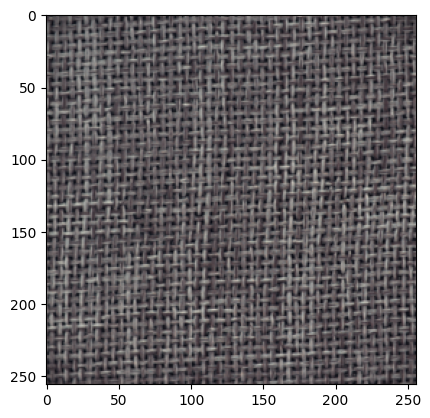

In [42]:
plt.imshow(x_val[0])
plt.show()

In [43]:
latent_dim = 1024

In [44]:
encoder_net = tf.keras.Sequential(
    [InputLayer(input_shape=(256, 256, 3)),
     Conv2D(64, 3, strides=2, padding='same', activation=tf.nn.relu),
     Conv2D(128, 3, strides=2, padding='same', activation=tf.nn.relu),
     Conv2D(256, 3, strides=2, padding='same', activation=tf.nn.relu),
     Conv2D(512, 3, strides=2, padding='same', activation=tf.nn.relu)])

decoder_net = tf.keras.Sequential(
    [InputLayer(input_shape=(latent_dim,)), Dense(16 * 16 * 64), Reshape(target_shape=(16, 16, 64)),
     Conv2DTranspose(256, 3, strides=2, padding='same', activation=tf.nn.relu),
     Conv2DTranspose(128, 3, strides=2, padding='same', activation=tf.nn.relu),
     Conv2DTranspose(64, 3, strides=2, padding='same', activation=tf.nn.relu),
     Conv2DTranspose(32, 3, strides=2, padding='same', activation=tf.nn.relu),
     Conv2DTranspose(3, 3, strides=1, padding='same', activation='sigmoid')])

In [48]:
od = OutlierVAE(threshold=.005, score_type='mse', encoder_net=encoder_net, decoder_net=decoder_net,latent_dim=latent_dim, )

In [54]:
import keras
import tensorflow as tf
tf.test.gpu_device_name()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Physical devices cannot be modified after being initialized


In [57]:
# %% Training
od.fit(x_train, epochs=10,batch_size=2,verbose=True)

ResourceExhaustedError: Exception encountered when calling layer "encoder_vae" (type EncoderVAE).

OOM when allocating tensor with shape[131072,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

Call arguments received by layer "encoder_vae" (type EncoderVAE):
  • x=tf.Tensor(shape=(2, 256, 256, 3), dtype=float32)

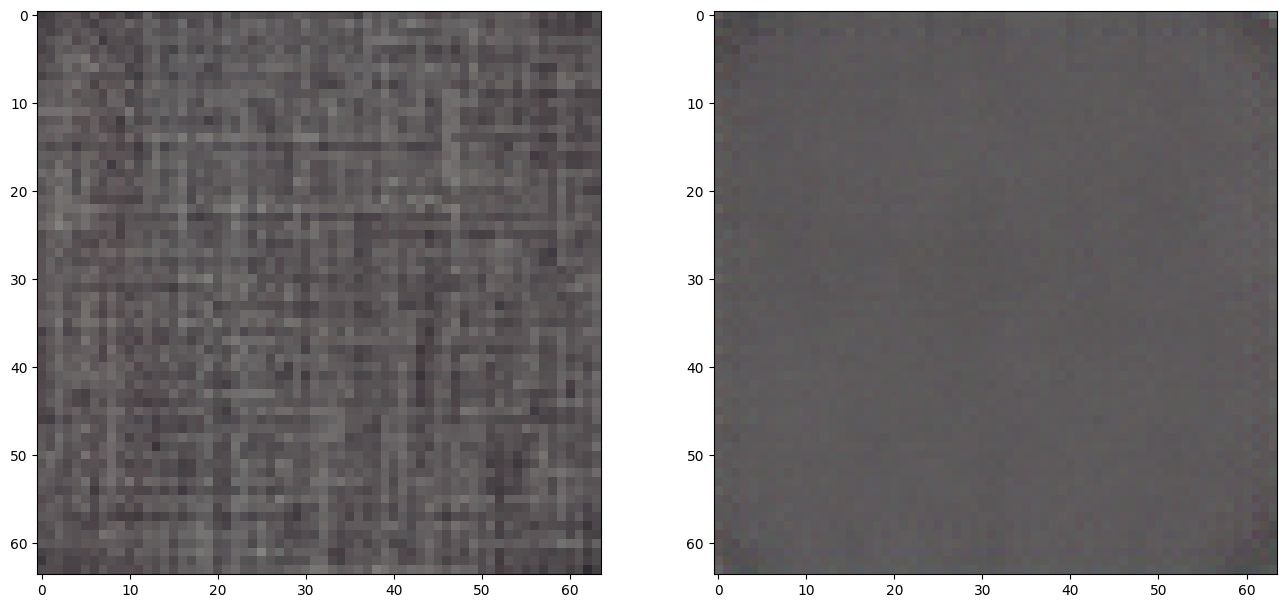

In [20]:
# %% Reconstruct Training Image
idx = 12
x = x_train[idx].reshape(1, 64, 64, 3)
x_recon = od.vae(x).numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())
plt.show()

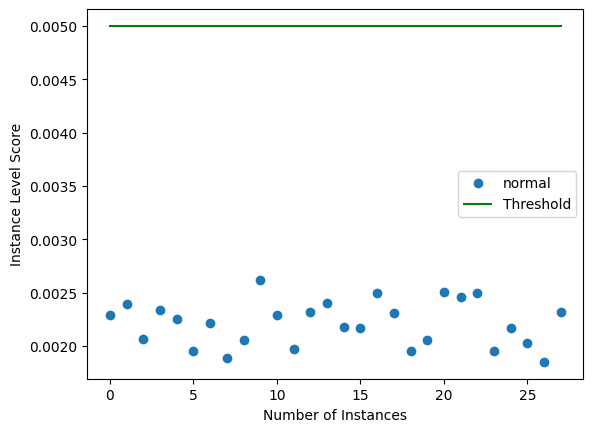

In [22]:
# %% Validation
od_preds = od.predict(x_val, outlier_type='instance', return_feature_score=True, return_instance_score=True)

target = np.zeros(x_val.shape[0], ).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

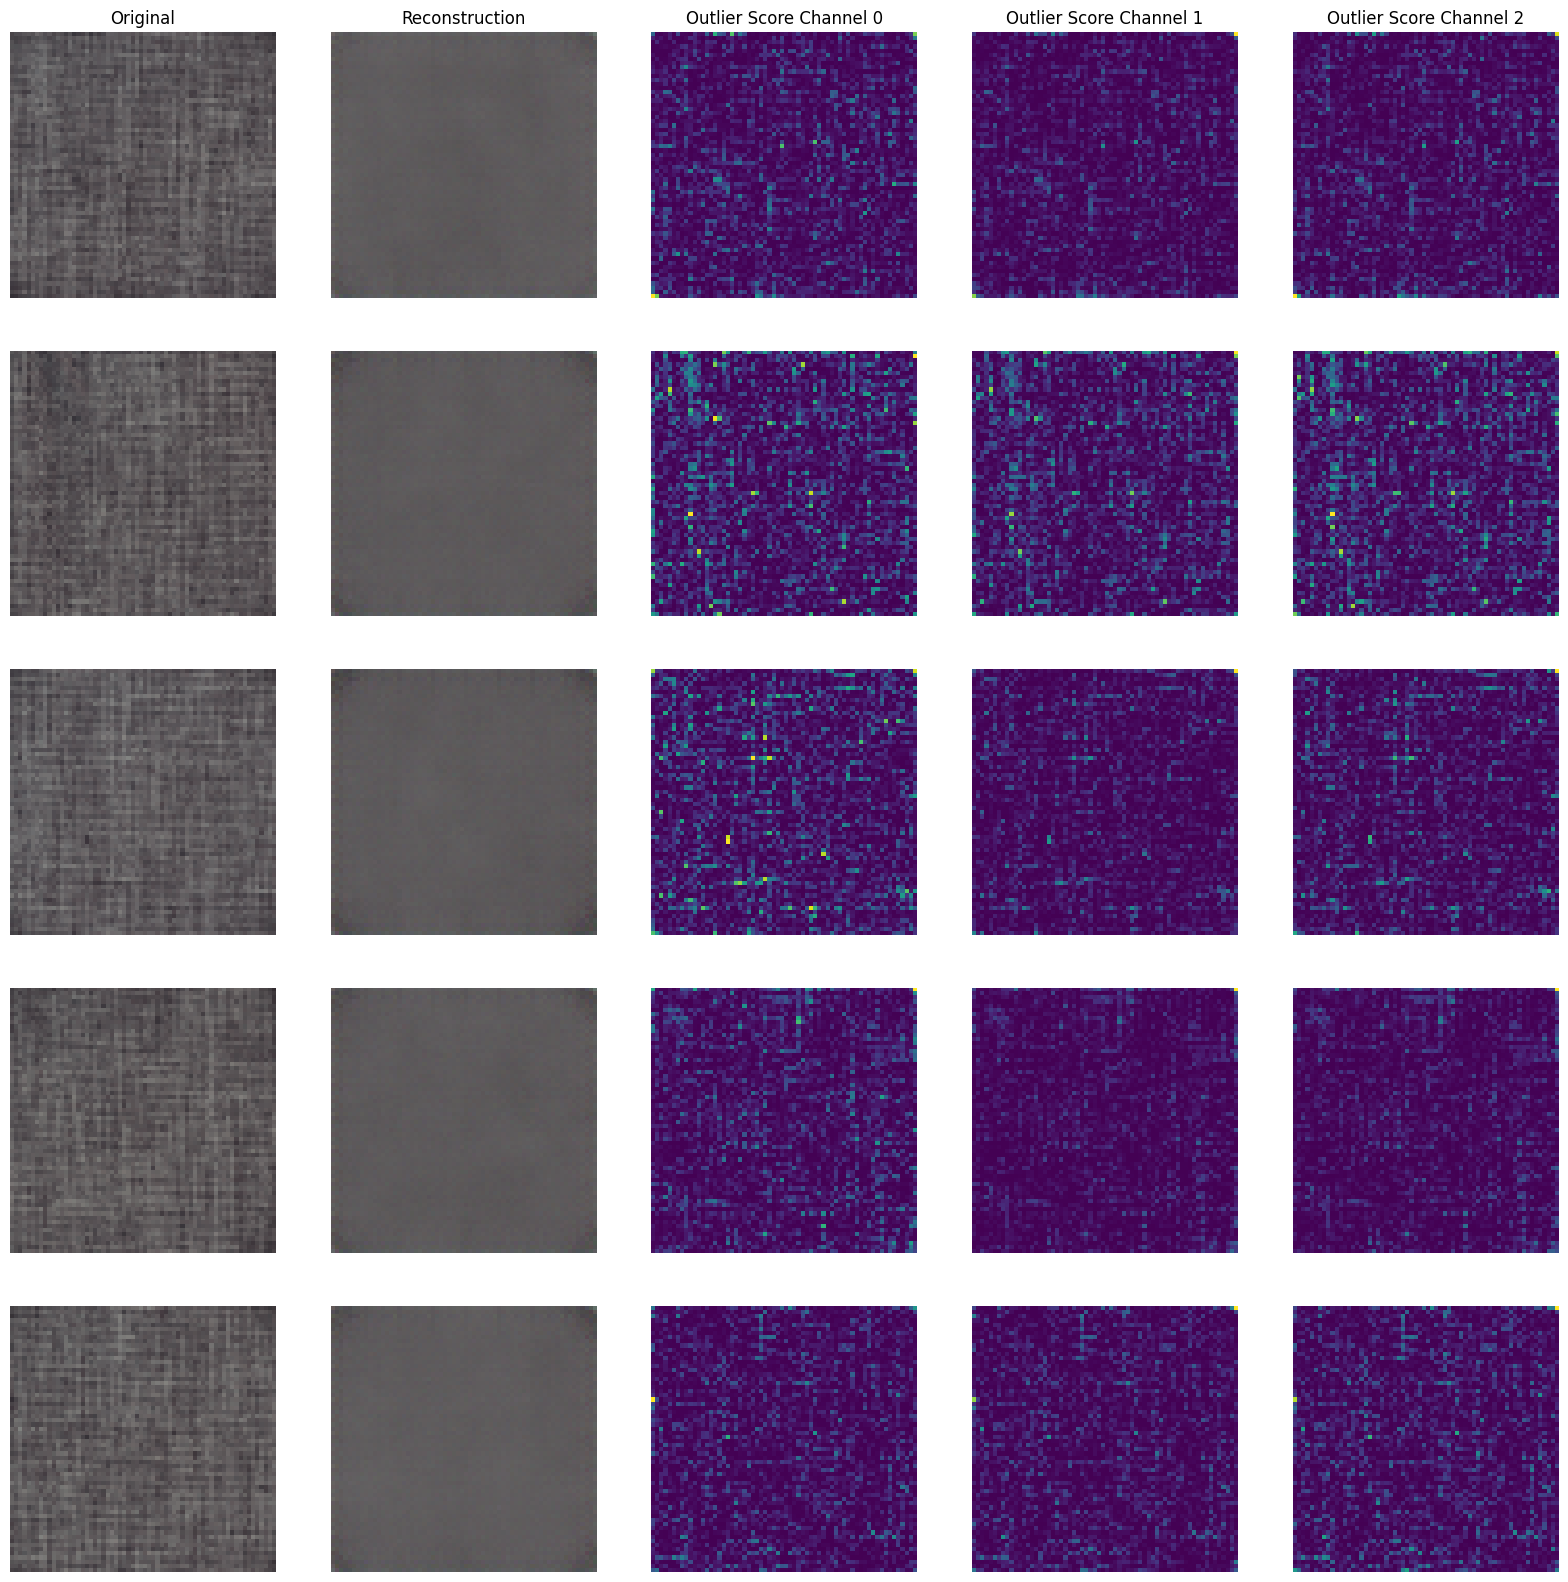

c:\Users\LEE CHANG YOUNG\Documents\GitHub\alibi-detect_test\alibi_detect\utils\visualize.py:83: UserWarning: No outliers found!
  warnings.warn('No outliers found!', UserWarning)


In [23]:
# %% Reconstruct Validation Images
x_recon = od.vae(x_val).numpy()

plot_feature_outlier_image(od_preds, x_val, X_recon=x_recon, max_instances=5, outliers_only=False)

# %% Outliers(존재한다면)
plot_feature_outlier_image(od_preds, x_val, X_recon=x_recon, max_instances=5, outliers_only=True)

In [24]:
test_img_list = glob('C:\\Users\\LEE CHANG YOUNG\\Documents\\GitHub\\alibi-detect_test\\ng_carpet\\*.png')

In [25]:
len(test_img_list)

89

In [26]:
x_test = img_to_np(test_img_list)
x_test = x_test.astype(np.float32) / 255.0

In [27]:
od_preds = od.predict(x_test, outlier_type='instance', return_feature_score=True, return_instance_score=True)


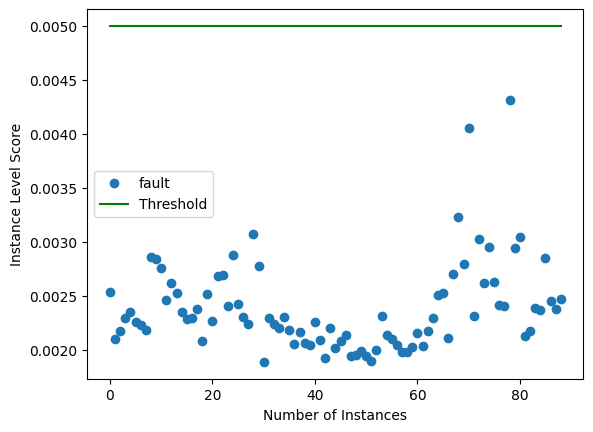

In [28]:
target = np.zeros(x_test.shape[0], ).astype(int)
labels = ['fault', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

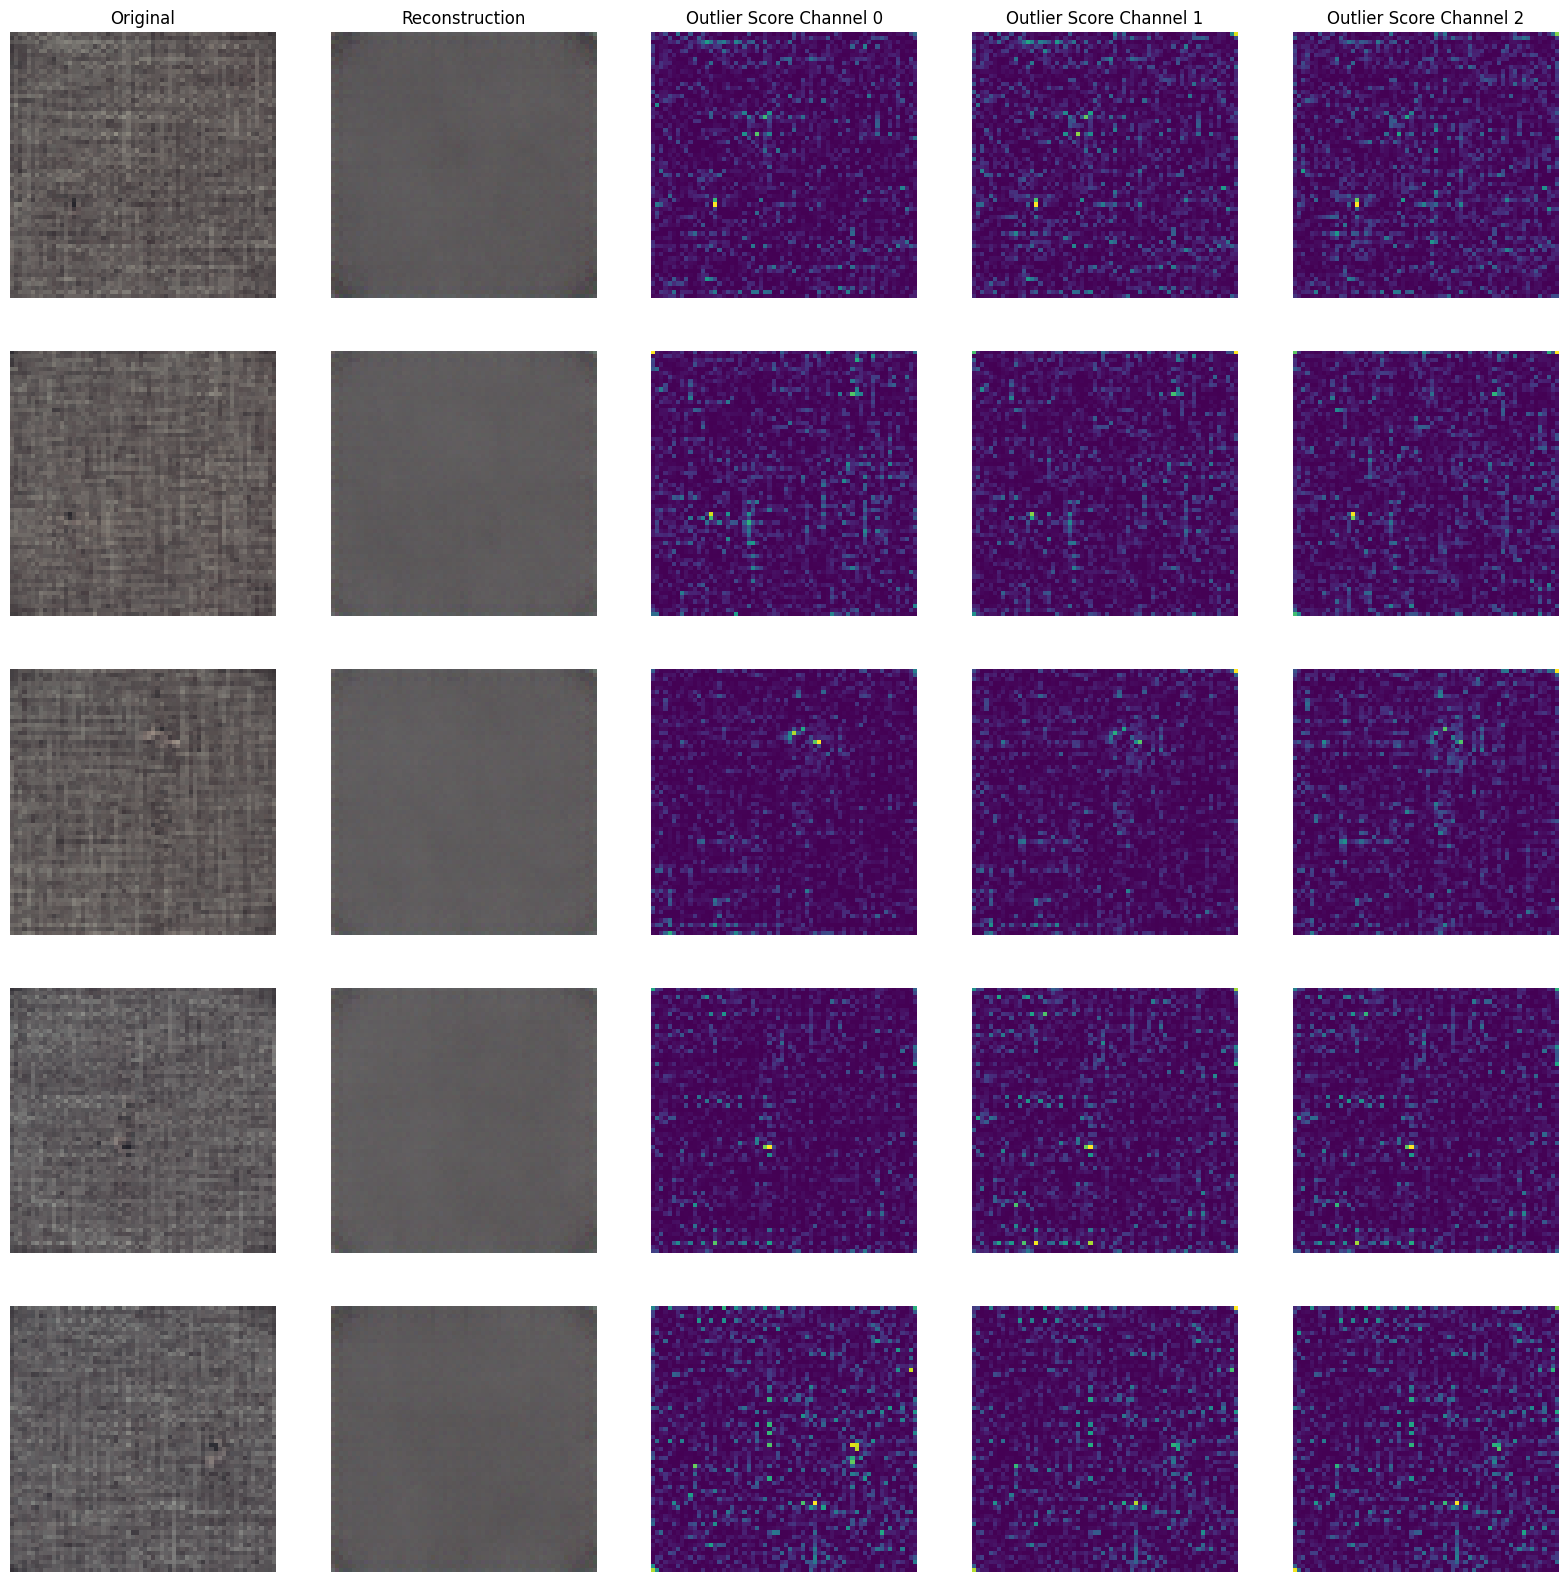

In [29]:
x_recon = od.vae(x_test).numpy()

plot_feature_outlier_image(od_preds, x_test, X_recon=x_recon, max_instances=5, outliers_only=False)